# Scrap code for adjusting plots during review process

Steinschneider Lab Group
Madeline Allen
Code last updated: 11/24/2025
Script purpose: Scrap code for adjusting plots during review process

Code based on current set up of plot_results_main.py script, changes will be copied over to that script.

This project utilizes code generated with the assistance of OpenAI's ChatGPT (November, 2025). 

In [1]:
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import Normalize, TwoSlopeNorm, LinearSegmentedColormap
import geopandas as gpd
import contextily as ctx
import arviz as az
import arviz.labels as azl
import xarray as xr
import seaborn as sns 
import copy
import sys
from pathlib import Path
#sys.path.append(str(Path(__file__).resolve().parent))
# local
import config
from config import MyLogger

Using 31 cores.


In [2]:
# Set up logger
current_script_name = 'scrap_code' #Path(__file__).stem
logger = MyLogger(config.log_path / f'log_{current_script_name}.txt')

# import from config
from config import (
    bayesian_traces_path,
    plots_path,
    selected_metrics,
    selected_lead_times,
    aggregation_periods,
    flow_thresholds,
    model_configs,
    metric_folder,
    data_path
)

selected_metrics_decadal = ['RMSE_norm', 'eCRPS_mean_std', 'rel']


ID_table = pd.read_csv(config.ID_Table_Basin_Char)
basin_char = config.basin_characteristics


# Color palettes
hex_colors=['#5c7fca', '#f7af58', '#a447a5', '#3e0281', '#6b7c93', '#ff880b', '#3d66bd', '#5c7fca']
hex_light_blue = '#c1ceeb'
hex_dark_yellow = '#f0880b'
hex_dark_blue = '#3d66bd'



In [3]:
def compile_model_results():
    trace_dir = bayesian_traces_path / f"traces_{agg_type}_Thresh{flow}/"
    if not trace_dir.exists():
        logger.log(f"Trace directory {trace_dir} does not exist. Skipping...")
        return {}, []

    model_results = {}
    for met in selected_metrics:
        for lead in selected_lead_times:
            for model_name_root in model_configs:
                base_model_name = f"{met}_{model_name_root}_ld{lead}"
                base_path = trace_dir / f"{base_model_name}_trace.nc"
                prior_path = trace_dir / f"{base_model_name}_prior.nc"

                if base_path.exists() and prior_path.exists():
                    trace = az.from_netcdf(base_path)
                    prior = az.from_netcdf(prior_path)
                    model_results[base_model_name] = {
                        "trace": trace,
                        "prior": prior
                    }

    print('model_results')
    print(model_results)
    model_list = list(model_results.keys())
    print('model_results.keys()', model_results.keys())
    return model_results, model_list


In [4]:
def compile_model_results_basinchar():
    trace_dir = bayesian_traces_path / f"traces_{agg_type}_Thresh{flow}_basinchar/"
    if not trace_dir.exists():
        logger.log(f"Trace directory {trace_dir} does not exist. Skipping...")
        return {}, []

    model_results = {}
    for met in selected_metrics:
        for lead in selected_lead_times:
            base_model_name = f"{met}_wet_time_ld{lead}"
            base_path = trace_dir / f"{base_model_name}_trace.nc"
            prior_path = trace_dir / f"{base_model_name}_prior.nc"

            if base_path.exists() and prior_path.exists():
                trace = az.from_netcdf(base_path)
                prior = az.from_netcdf(prior_path)
                model_results[base_model_name] = {
                    "trace": trace,
                    "prior": prior
                }

    print('model_results')
    print(model_results)
    model_list = list(model_results.keys())
    print('model_results.keys()', model_results.keys())
    return model_results, model_list


In [48]:
def plot_decadal_metric():
    """
    Creates a 2-row figure with:
    - Top row: Maps of average performance metrics.
    - Bottom row: Scatter plots comparing performance metrics between lead times.

    Parameters:
    df (DataFrame): Data containing site information and metrics.
    lead_map (int): Lead time used for maps in the top row.
    lead_xaxis (int): Lead time for x-axis in scatter plots.
    lead_yaxis (int): Lead time for y-axis in scatter plots.
    metrics (list): List of three metrics to plot.
    """
    

    fig, axes = plt.subplots(2, 3, figsize=(16, 10), gridspec_kw={'height_ratios': [1.38, 1]})
    lead_xaxis = 1
    lead_yaxis = 5
    axis_font_size = 16

    # top row: maps of average performance metrics
    df_merged = ID_table.copy().reset_index(drop=True)[['CNRFC_id', 'LNG_GAGE', 'LAT_GAGE']].merge(
        df_metric_decade, how='right', left_on='CNRFC_id', right_on='site')
    metric_df = df_merged[df_merged['lead'] == 1]

    # Create a base GeoDataFrame
    gdf_base = gpd.GeoDataFrame(
        metric_df,
        geometry=gpd.points_from_xy(metric_df['LNG_GAGE'], metric_df['LAT_GAGE']),
        crs="EPSG:4269"
    ).to_crs(epsg=3857)

    for i, metric in enumerate(selected_metrics_decadal):
        gdf = gdf_base.copy()
        main_color = hex_colors[3]

        # Define color normalization
        vmin_90_10, vmax_90_10 = np.percentile(gdf[metric], [10, 90])
        if vmin_90_10 > 0:
            norm = Normalize(vmin=vmin_90_10, vmax=vmax_90_10)
            cmap = LinearSegmentedColormap.from_list("custom_cmap", [hex_colors[3], hex_light_blue, hex_colors[1]]) #[hex_colors[0], hex_colors[4], hex_colors[2]]
        elif vmax_90_10 < 0:
            norm = Normalize(vmin=vmin_90_10, vmax=vmax_90_10)
            cmap = LinearSegmentedColormap.from_list("custom_cmap", ['mediumblue', 'white'])
        else:
            max_range = max(abs(vmin_90_10), abs(vmax_90_10))
            norm = TwoSlopeNorm(vmin=-max_range, vcenter=0, vmax=max_range)
            cmap = LinearSegmentedColormap.from_list("custom_cmap", ['mediumblue', 'white', 'firebrick'])

        # Plot the map
        gdf.plot(ax=axes[0, i], color=[cmap(norm(val)) for val in gdf[metric]], markersize=50, edgecolor='k', alpha=0.8)
        ctx.add_basemap(axes[0, i], source=ctx.providers.Esri.WorldTopoMap, alpha=0.7, attribution="")
        axes[0, i].set_xticks([]), axes[0, i].set_yticks([])

        # Colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = fig.colorbar(sm, ax=axes[0, i], orientation='vertical', fraction=0.05)
        cbar.ax.tick_params(labelsize=11)
        if metric == 'RMSE_norm':
            cbar.set_label('Average Decadal Normalized RMSE', fontsize=axis_font_size)
        elif metric == 'eCRPS_mean_std':
            cbar.set_label('Average Decadal Normalized eCRPS', fontsize=axis_font_size)
        elif metric == 'rel':
            cbar.set_label('Average Decadal Reliability', fontsize=axis_font_size)
        else:
            cbar.set_label(f'Average {metric}', fontsize=axis_font_size)

    # bottom row - scatter plots comparing lead times
    for i, metric in enumerate(selected_metrics_decadal):
        # Filter once and pivot so each site has one row, columns = lead times
        df_pivot = df_merged[df_merged['lead'].isin([lead_xaxis, lead_yaxis])][['site', 'lead', metric]]
        df_wide = df_pivot.pivot(index='site', columns='lead', values=metric).dropna()

        x_vals = df_wide[lead_xaxis]
        y_vals = df_wide[lead_yaxis]

        ax = axes[1, i]
        ax.scatter(x_vals, y_vals, c=main_color, alpha=0.5, label='Forecast Points')

        # 1:1 Line (diagonal line)
        all_vals = np.concatenate([x_vals.values, y_vals.values])
        buffer = (all_vals.max() - all_vals.min()) * 0.05
        lims = [all_vals.min() - buffer, all_vals.max() + buffer]
        ax.plot(lims, lims, 'k--', linewidth=1, label='1:1 Line')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        # Set aspect ratio and tick locators
        ax.set_aspect('equal', adjustable='box')
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))#, steps=[1, 2, 5, 10]))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))#, steps=[1, 2, 5, 10]))
        ax.grid(True)
        ax.tick_params(labelsize=11)

        # Labels
        if metric == 'RMSE_norm':
            ax.set_xlabel(f'Normalized RMSE Lead {lead_xaxis}', fontsize=axis_font_size)
            ax.set_ylabel(f'Normalized RMSE Lead {lead_yaxis}', fontsize=axis_font_size)
        elif metric == 'eCRPS_mean_std':
            ax.set_xlabel(f'Normalized eCRPS Lead {lead_xaxis}', fontsize=axis_font_size)
            ax.set_ylabel(f'Normalized eCRPS Lead {lead_yaxis}', fontsize=axis_font_size)
        elif metric == 'rel':
            ax.set_xlabel(f'Reliability Lead {lead_xaxis}', fontsize=axis_font_size)
            ax.set_ylabel(f'Reliability Lead {lead_yaxis}', fontsize=axis_font_size)
        else:
            ax.set_xlabel(f'Lead {lead_xaxis}', fontsize=axis_font_size)
            ax.set_ylabel(f'Lead {lead_yaxis}', fontsize=axis_font_size)

    # Global Title
    fig.suptitle(f'Decadal Forecast Performance', fontsize=20)
    plt.tight_layout()
    plt.savefig(folder_path / f'Decadal_performance.png', dpi=300, bbox_inches='tight')
    #plt.show()



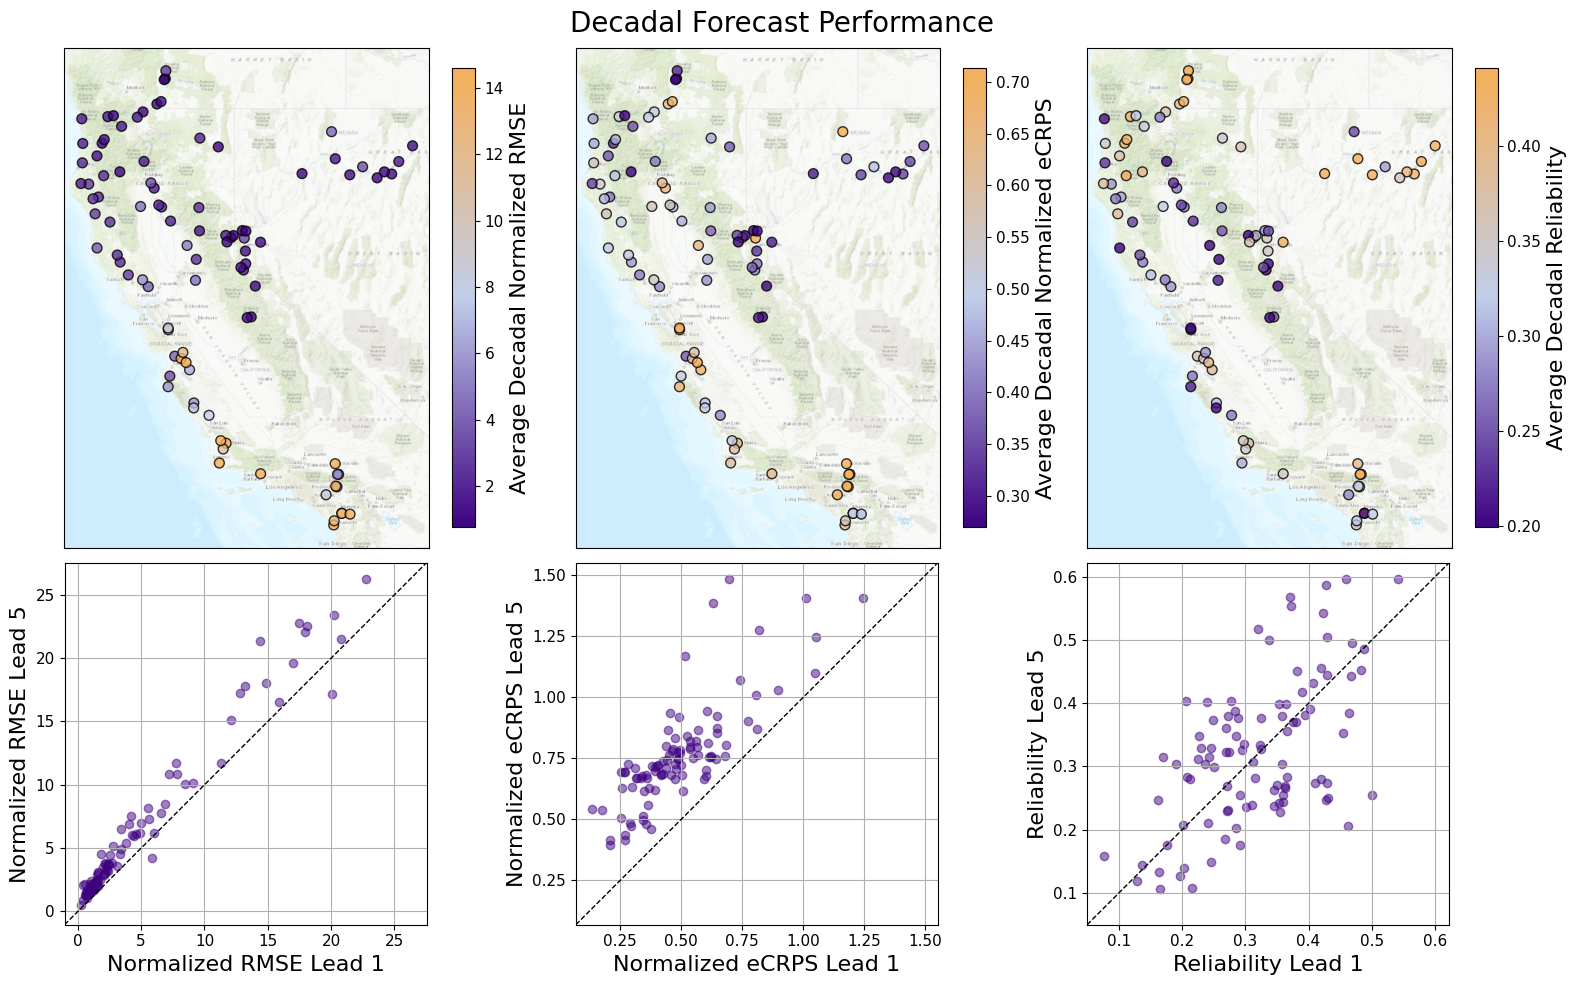

In [ ]:
# plot_decadal_metric()

In [6]:
def create_trace_with_placeholders(trace, required_vars):
    new_data = {}
    original_vars = trace.posterior.data_vars

    chain_dim = trace.posterior.sizes['chain']
    draw_dim = trace.posterior.sizes['draw']

    for var in required_vars:
        if var in original_vars:
            # Keep the full DataArray (preserve dimensions beyond chain/draw)
            new_data[var] = trace.posterior[var]
        else:
            # Create placeholder NaN DataArray with shape (chain, draw)
            nan_array = np.full((chain_dim, draw_dim), np.nan)
            new_data[var] = xr.DataArray(nan_array, dims=["chain", "draw"])

    # Preserve coordinates if needed (optional, for arviz compatibility)
    coords = copy.deepcopy(trace.posterior.coords)

    # Create a new posterior dataset
    new_posterior = xr.Dataset(new_data, coords=coords)

    return az.InferenceData(posterior=new_posterior)


In [7]:
# Plot all global params - helpful for examining e.g., multicollinearity
def plot_global_params_all():
    required_vars = ['mu_wet', 'sigma_wet', 'mu_time', 'sigma_time', 'mu_AR', 'sigma_AR', 'mu_GEFS', 'sigma_GEFS']
    hdi_prob_selected = 0.90

    for met in selected_metrics:
        for lead in selected_lead_times:

            model_list_filtered = [
                model for model in model_list 
                if model.startswith(f"{met}_") and model.endswith(f"_ld{lead}")
            ]
            if not model_list_filtered:
                continue

            prepared_traces = [
                create_trace_with_placeholders(model_results[model]['trace'], required_vars)
                for model in model_list_filtered
            ]

            custom_palette = sns.color_palette("husl", len(model_list_filtered))

            fig, ax = plt.subplots(figsize=(12, 8))
            az.plot_forest(
                prepared_traces,
                model_names=model_list_filtered,
                var_names=required_vars,
                combined=True,
                hdi_prob=hdi_prob_selected,
                colors=custom_palette,
                ax=ax,
            )

            ax.axvline(0, color='black', linestyle='--', linewidth=1)

            # Title
            if met == 'eCRPS_mean':
                ax.set_title(f'Comparison of Global Parameters Across Models (eCRPS, lead {lead}); HDI = {hdi_prob_selected}')
            elif met == 'rel':
                ax.set_title(f'Comparison of Global Parameters Across Models (Reliability, lead {lead}); HDI = {hdi_prob_selected}')
            else:
                ax.set_title(f'Comparison of Global Parameters Across Models ({met}, lead {lead}); HDI = {hdi_prob_selected}')

            ax.grid(True, linestyle="--", alpha=0.5)
            plt.tight_layout()

            filename = folder_path_global_params / f'Global_params_mu_{met}_ld{lead}.png'
            if filename.exists():
                filename.unlink()
            plt.savefig(filename, dpi=300)
            plt.close()



In [8]:
# Plot just regional average global params - helpful for examining multicollinearity in streamlined way
def plot_global_params_mu():
    required_vars = ['mu_wet', 'mu_time', 'mu_AR', 'mu_GEFS']
    hdi_prob_selected = 0.90

    for met in selected_metrics:
        for lead in selected_lead_times:

            model_list_filtered = [
                model for model in model_list 
                if model.startswith(f"{met}_") and model.endswith(f"_ld{lead}")
            ]
            if not model_list_filtered:
                continue

            # Extract predictor labels for legend (e.g., "wet_time_AR" -> "wet + time + AR")
            model_legend_labels = [
                model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ")
                for model in model_list_filtered
            ]

            prepared_traces = [
                create_trace_with_placeholders(model_results[model]['trace'], required_vars)
                for model in model_list_filtered
            ]

            #custom_palette = sns.color_palette("husl", len(model_list_filtered))
            custom_palette = sns.color_palette("Paired", len(model_list_filtered))

            labeller = azl.mix_labellers(
                (azl.MapLabeller, azl.DimCoordLabeller, azl.NoModelLabeller)
            )(
                var_name_map={
                    "mu_wet": r"$\mu$ wet",
                    "mu_time": r"$\mu$ time",
                    "mu_AR": r"$\mu$ AR",
                    "mu_GEFS": r"$\mu$ GEFS",
                }
            )

            fig, ax = plt.subplots(figsize=(12, 8))
            az.plot_forest(
                prepared_traces,
                model_names=model_legend_labels,  # <- simplified legend labels here
                var_names=required_vars,
                combined=True,
                hdi_prob=hdi_prob_selected,
                colors=custom_palette,
                ax=ax,
                labeller=labeller,
            )

            ax.axvline(0, color='black', linestyle='--', linewidth=1)

            # Title
            if met == 'eCRPS_mean':
                ax.set_title(f'Comparison of Global Parameters Across Models (eCRPS, lead {lead}); HDI = {hdi_prob_selected}')
            elif met == 'rel':
                ax.set_title(f'Comparison of Global Parameters Across Models (Reliability, lead {lead}); HDI = {hdi_prob_selected}')
            else:
                ax.set_title(f'Comparison of Global Parameters Across Models ({met}, lead {lead}); HDI = {hdi_prob_selected}')

            ax.grid(True, linestyle="--", alpha=0.5)
            plt.tight_layout()

            filename = folder_path_global_params / f'Global_params_mu_{met}_ld{lead}.png'
            if filename.exists():
                filename.unlink()
            plt.savefig(filename, dpi=300)
            plt.close()




In [9]:
def plot_global_params_mu_ld15():
    required_vars = ['mu_wet', 'mu_time', 'mu_AR', 'mu_GEFS']
    hdi_prob_selected = 0.90

    # Define the metric and lead ordering
    metrics_order = ['RMSE', 'eCRPS_mean', 'rel']
    leads_order = [1, 5]

    # Set up figure and axes: 3 rows (metrics), 2 columns (leads)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=False)

    # Custom labeller for μ variable names
    labeller = azl.mix_labellers(
        (azl.MapLabeller, azl.DimCoordLabeller, azl.NoModelLabeller)
    )(
        var_name_map={
            "mu_wet": r"$\mu$ wet",
            "mu_time": r"$\mu$ time",
            "mu_AR": r"$\mu$ AR",
            "mu_GEFS": r"$\mu$ GEFS",
        }
    )

    for row_idx, met in enumerate(metrics_order):
        for col_idx, lead in enumerate(leads_order):

            model_list_filtered = [
                model for model in model_list 
                if model.startswith(f"{met}_") and model.endswith(f"_ld{lead}")
            ]
            if not model_list_filtered:
                continue

            # Simplified model names for legend
            model_legend_labels = [
                model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ")
                for model in model_list_filtered
            ]

            prepared_traces = [
                create_trace_with_placeholders(model_results[model]['trace'], required_vars)
                for model in model_list_filtered
            ]

            custom_palette = sns.color_palette("Paired", len(model_list_filtered))
            ax = axes[row_idx, col_idx]

            az.plot_forest(
                prepared_traces,
                model_names=model_legend_labels,
                var_names=required_vars,
                combined=True,
                hdi_prob=hdi_prob_selected,
                colors=custom_palette,
                ax=ax,
                labeller=labeller,
                legend=False, 
            )

            ax.axvline(0, color='black', linestyle='--', linewidth=1)
            ax.grid(True, linestyle="--", alpha=0.5)

            # Add subplot title
            if row_idx == 0:
                ax.set_title(f"Lead {lead}", fontsize=12)
            #otherwise, remove subplot title that currently says 90% HDI
            else:
                ax.set_title(None)

                
            if col_idx == 0:
                if met == 'eCRPS_mean':
                    ax.set_ylabel("eCRPS", fontsize=12)
                elif met == 'rel':
                    ax.set_ylabel("Reliability", fontsize=12)
                else:
                    ax.set_ylabel(met, fontsize=12)

    # Tight layout and save
    plt.tight_layout(rect=[0, 0.1, 1, 1]) 


    # Add legend - shared legend for the whole figure (use final palette + labels from last plot)
    handles = [
        mlines.Line2D([0], [0], color=custom_palette[i], lw=4)
        for i in range(len(model_legend_labels))
    ]
    fig.legend(
        handles,
        model_legend_labels,
        title="Predictors",
        loc="lower center",
        bbox_to_anchor=(0.5, -0.02),
        fontsize="medium",
        title_fontsize="medium",
        frameon=True,
        ncol=2
    )

    fig.suptitle("Global Parameters Across Metrics and Lead Times (90% HDI)", fontsize=14, y=1.02)

    filename = folder_path_global_params / 'Global_params_mu_all_metrics_ld1_ld5.png'
    if filename.exists():
        filename.unlink()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()



In [10]:
def plot_mu_wet_time_lead_comp():
     # Figure for paper - wet + time comparison
    hdi_prob_selected = 0.90

    # Create the figure with 3 subplots
    fig, axes = plt.subplots(len(selected_metrics), 1, figsize=(8, 8))  # Vertical layout for the subplots

    # If there's only one subplot, make sure it's iterable
    if len(selected_metrics) == 1:
        axes = [axes]

    # Define the labeller to map 'mu_wet' and 'mu_time' to custom labels
    labeller = azl.mix_labellers((azl.MapLabeller, azl.DimCoordLabeller, azl.NoModelLabeller))(var_name_map={"mu_wet": r"$\mu$ wet", "mu_time": r"$\mu$ time"})

    # Iterate through each metric and subplot
    for i, met in enumerate(selected_metrics):

        model_list_wet_time = []

        for lead in selected_lead_times:
            model_name = f"{met}_wet_time_ld{lead}"
            if model_name in model_results and model_name not in model_list_wet_time:
                model_list_wet_time.append(model_name)

        print('model_list_wet_time', model_list_wet_time)
        # Number of models for color palette
        num_models = len(model_list_wet_time)
        
        custom_palette = hex_colors[:len(model_list_wet_time)]

        prepared_traces = [
            model_results[model]['trace']
            for model in model_list_wet_time
        ]

        # Plot the forest plot on the respective axis (subplot)
        az.plot_forest(
            prepared_traces,
            model_names=model_list_wet_time,
            var_names=['mu_wet', 'mu_time'],  # Variables to plot (must match the model's names)
            combined=True,
            hdi_prob=hdi_prob_selected,
            figsize=(3, 6),  # Adjust figsize for subplots
            colors=custom_palette,
            ax=axes[i],  # Pass the specific axis for each subplot
            labeller=labeller,  # Use the labeller here
            legend=False,
        )

        # Add vertical reference line at 0
        axes[i].axvline(0, color='black', linestyle='--', linewidth=1)

        # Set the title based on the metric name
        if met == 'eCRPS_mean':
            axes[i].set_title('eCRPS')
        elif met == 'rel':
            axes[i].set_title('Reliability')
        else:
            axes[i].set_title(met)  # Keep 'RMSE' as it is

        # Create custom legend using Line2D (all legends for subfigs are the same)
        if i == 0:
            lead_labels = [f"Lead {model.split('_ld')[1]}" for model in model_list_wet_time]
            handles = [mlines.Line2D([0], [0], color=custom_palette[idx], lw=4) for idx in range(num_models)]

        axes[i].grid(True, linestyle="--", alpha=0.5)  


    # Adjust layout to prevent overlapping of titles and axes labels
    plt.tight_layout(rect=[0, 0, 0.88, 1])

    # Shared legend to the right of the whole figure
    fig.legend(
        handles,
        lead_labels,
        title="Lead Time",
        loc='center left',
        bbox_to_anchor=(0.88, 0.5),  # Adjust as needed
        borderaxespad=0,
        fontsize='small'
    )

    # Save figure (remove file if it already exists)
    filename = folder_path / 'Regional_mu_wet_time_lead_comparison.png'



    if filename.exists():
        filename.unlink()  # Remove existing file if necessary
    plt.savefig(filename, dpi=300)

    # Show the plot
    #plt.show()


In [11]:
def plot_model_comp_waic():
     for lead in selected_lead_times:
        fig, axes = plt.subplots(len(selected_metrics), 1, figsize=(8, 10))  # Vertical layout

        if len(selected_metrics) == 1:  # Ensure axes is always iterable
            axes = [axes]

        for i, (ax, met) in enumerate(zip(axes, selected_metrics)):  # Loop through metrics and subplots
            model_results_traces = {}

            pattern = re.compile(f"{met}_.+_ld{lead}")
            model_list_filtered = [model for model in model_list if pattern.fullmatch(model)]


            for m in model_list_filtered:
                model_results_traces[m] = model_results[m]['trace']
            
            # Model comparison: WAIC
            df_comp_waic = az.compare(compare_dict=model_results_traces, ic="waic")

            # Reverse index order so best models appear on top **for this metric**
            models = df_comp_waic.index[::-1]
            y_pos = np.arange(len(models))

            # Extract values
            elpd_waic = df_comp_waic["elpd_waic"].values[::-1]
            #calculate waic as -2 * elpd_waic to put it on deviance scale (lower is better)
            waic = -2*elpd_waic

            elpd_waic_se = df_comp_waic["se"].values[::-1]
            # convert standard error in elpd_waic into deviance scale as well via multiply by 2, then multiply by 2 again for 2 standard errors:
            #waic_se = 2 * elpd_waic_se
            waic_2se = 2 * elpd_waic_se * 2
            best_waic = np.min(waic)

            # Transform model names for y-axis labels
            formatted_labels = [
                model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ") for model in models
            ]

            # Plot elpd_waic (dot + error bars)
            ax.errorbar(waic, y_pos, xerr=waic_2se, fmt='o', label="WAIC ± 2SE", color=hex_colors[0], capsize=4) # 4052D6 royalblue #775baf  hex_colors[1] hex_colors[3]

            # Add a vertical line at best_elpd
            ax.axvline(x=best_waic, color='grey', linestyle='--', label='Best WAIC')

            # **Set Y-axis labels (now unique per subplot)**
            ax.set_yticks(y_pos)
            ax.set_yticklabels(formatted_labels)

            # Set the title based on the metric name
            if met == 'eCRPS_mean':
                ax.set_title('eCRPS')
            elif met == 'rel':
                ax.set_title('Reliability')
            else:
                ax.set_title(met)  # Keep 'RMSE' as it is

            # Add legend only for the first subplot
            if i == 0:
                ax.legend()

            ax.grid(True, linestyle="--", alpha=0.5)

            ax.set_xlabel("WAIC") #(log)
            
        # Adjust layout to prevent overlapping
        plt.suptitle(f'Model Comparison WAIC (Lead {lead})')
        plt.tight_layout()

        # Save figure for this lead time
        filename = folder_path /f'Model_comp_waic_ld{lead}.png'
        if filename.exists():
            filename.unlink()
        plt.savefig(filename, dpi=300, bbox_inches='tight')



In [12]:
# Same as above, but combining lead 1 and lead 5 subplots (lead 1 left column; lead 5 right column)
def plot_model_comp_waic_ld15():
    leads = [1, 5]
    n_rows = len(selected_metrics)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 3.5 * n_rows), sharey=False)

    if n_rows == 1:
        axes = np.array([axes])  # Ensure axes is 2D even if one row

    for col, lead in enumerate(leads):  # col=0 for lead 1, col=1 for lead 5
        for row, met in enumerate(selected_metrics):
            ax = axes[row, col]
            model_results_traces = {}

            # Filter model names for this metric and lead
            pattern = re.compile(f"{met}_.+_ld{lead}")
            model_list_filtered = [model for model in model_list if pattern.fullmatch(model)]

            for m in model_list_filtered:
                model_results_traces[m] = model_results[m]['trace']

            if not model_results_traces:
                ax.set_visible(False)
                continue

            # WAIC comparison
            df_comp_waic = az.compare(compare_dict=model_results_traces, ic="waic")
            models = df_comp_waic.index[::-1]
            y_pos = np.arange(len(models))

            elpd_waic = df_comp_waic["elpd_waic"].values[::-1]
            waic = -2 * elpd_waic
            waic_2se = 2 * df_comp_waic["se"].values[::-1] * 2
            best_waic = np.min(waic)

            # Format labels like "AR + Qobs"
            formatted_labels = [
                model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ") for model in models
            ]

            # Plot
            ax.errorbar(waic, y_pos, xerr=waic_2se, fmt='o', label="WAIC ± 2SE", color=hex_colors[0], capsize=4)
            ax.axvline(x=best_waic, color='grey', linestyle='--', label='Best WAIC')

            # Show y-axis labels for both subplots
            ax.set_yticks(y_pos)
            ax.set_yticklabels(formatted_labels)
            ax.set_xlabel('WAIC', fontsize=12)
            ax.grid(True, linestyle="--", alpha=0.5)

            # Title per subplot
            if met == 'eCRPS_mean':
                ax.set_title(f'eCRPS (Lead {lead})', fontsize=13)
            elif met == 'rel':
                ax.set_title(f'Reliability (Lead {lead})', fontsize=13)
            else:
                ax.set_title(f'{met} (Lead {lead})', fontsize=13)

    # Place shared legend to the right
    handles = [
        mlines.Line2D([], [], color=hex_colors[0], marker='o', linestyle='None', label='WAIC ± 2SE'),
        mlines.Line2D([], [], color='grey', linestyle='--', label='Best WAIC')
    ]
    #legend to right: 
    # fig.legend(handles=handles, loc='center right', bbox_to_anchor=(0.98, 0.5), fontsize=11)
    # plt.tight_layout(rect=[0, 0, 0.88, 1])  # Leave space on right for legend
    
    # or legend below:
    fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=11)
    plt.tight_layout(rect=[0, 0.02, 1, 1])


    filename = folder_path / 'Model_comp_waic_ld1_ld5.png'
    if filename.exists():
        filename.unlink()
    plt.savefig(filename, dpi=300, bbox_inches='tight')



In [41]:
def plot_beta_time_maps(): #model_list, model_results, df=df_metric
    selected_metrics = ['RMSE', 'eCRPS_mean', 'rel']
    leads = [1, 5]
    fig, axes = plt.subplots(2, 3, figsize=(14, 10))
    axes = axes.reshape(2, 3) 
    axis_font_size = 20

    for row_idx, lead in enumerate(leads):
        for col_idx, met in enumerate(selected_metrics):
            ax = axes[row_idx][col_idx]
            model_name = f"{met}_wet_time_ld{lead}"

            if model_name not in model_list:
                print(f"Model {model_name} not found in model_list.")
                continue

            trace = model_results[model_name]['trace']

            posterior_medians = [
                np.median(trace.posterior['beta_time'].values[:, :, site_index])
                for site_index in range(len(selected_sites))
            ]

            medians_df = pd.DataFrame({
                'site': selected_sites,
                'posterior_param_medians': posterior_medians
            })

            merged_df = ID_table.copy().reset_index(drop=True)[['CNRFC_id', 'LNG_GAGE', 'LAT_GAGE']].merge(
                medians_df, how = 'right', left_on='CNRFC_id', right_on='site'
            )

            gdf = gpd.GeoDataFrame(
                merged_df,
                geometry=gpd.points_from_xy(merged_df['LNG_GAGE'], merged_df['LAT_GAGE']),
                crs="EPSG:4269"
            ).to_crs(epsg=3857)

            min_val, max_val = gdf['posterior_param_medians'].min(), gdf['posterior_param_medians'].max()
        
            pos_color = hex_dark_yellow
            neg_color = hex_dark_blue
            neutral_color = 'white'

            
            
            if min_val > 0:
                norm = Normalize(vmin=min_val, vmax=max_val)
                colors = [neutral_color, pos_color]
            elif max_val < 0:
                norm = Normalize(vmin=min_val, vmax=max_val)
                colors = [neg_color, neutral_color]
            else:
                max_range = max(abs(min_val), abs(max_val))
                norm = TwoSlopeNorm(vmin=-max_range, vcenter=0, vmax=max_range)
                colors = [neg_color, neutral_color, pos_color]

            cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

            gdf.plot(
                ax=ax,
                color=[cmap(norm(v)) for v in gdf['posterior_param_medians']],
                markersize=50, edgecolor='k', alpha=0.8
            )

            x_min, y_min, x_max, y_max = gdf.total_bounds
            ax.set_xlim(x_min - 0.1 * (x_max - x_min), x_max + 0.1 * (x_max - x_min))
            ax.set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))

            ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap, alpha=0.7, attribution="")
            ax.set_xticks([]); ax.set_yticks([])

            # Colorbar
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.04, pad=0.01)
            cbar.set_label(r'Median $\beta_{time}$', fontsize=(axis_font_size-3))
            cbar.ax.tick_params(labelsize=10)

            # Subplot title for top row (metrics)
            if row_idx == 0:
                if met == 'eCRPS_mean':
                    title = 'eCRPS'
                elif met == 'rel':
                    title = 'Reliability'
                else:
                    title = met
                ax.set_title(title, fontsize=axis_font_size, pad=10)

            # Y-axis label for left column (lead times)
            if col_idx == 0:
                ax.set_ylabel(f'Lead {lead}', fontsize=axis_font_size, labelpad=10)

    plt.tight_layout()#rect=[0, 0, 1, 1])

    filename = folder_path / f'Map_median_beta_time_lead15comp.png'
    if filename.exists():
        filename.unlink()
    plt.savefig(filename, dpi=300)
    #plt.show()



In [43]:
# plot_beta_time_maps()

In [14]:
def plot_beta_time_positive():
    sel_metrics = ['RMSE']
    leads = [1]

    for row_idx, lead in enumerate(leads):
        for col_idx, met in enumerate(sel_metrics):
            model_name = f"{met}_wet_time_ld{lead}"

            if model_name not in model_list:
                print(f"Model {model_name} not found in model_list.")
                continue

            trace = model_results[model_name]['trace']

            # Get median beta_time across all draws and chains (1 per site)
            beta_medians = trace.posterior['beta_time'].median(dim=("chain", "draw")).values.flatten()

            medians_df = pd.DataFrame({
                'site': selected_sites,
                'posterior_param_medians': beta_medians
            })

            merged_df = ID_table.copy().reset_index(drop=True)[['CNRFC_id', 'LNG_GAGE', 'LAT_GAGE']].merge(
                medians_df, how='right', left_on='CNRFC_id', right_on='site'
            )

            # Save medians to CSV
            folder_path_median_beta = folder_path / 'median_beta_time'
            folder_path_median_beta.mkdir(parents=True, exist_ok=True)
            merged_df.to_csv(folder_path_median_beta / f'median_beta_time_{met}_ld{lead}.csv', index=False)

            # Filter sites with positive median beta_time
            positive_sites = merged_df[merged_df["posterior_param_medians"] > 0]["site"].tolist()

            # Filter metric data for selected sites
            df_plot = df_metric[
                (df_metric["lead"] == lead) &
                (df_metric["site"].isin(positive_sites))
            ]

            # Plot RMSE over time for each site
            for site in positive_sites:
                site_df = df_plot[df_plot["site"] == site]

                if site_df.empty:
                    continue

                plt.figure(figsize=(6, 4))
                plt.plot(site_df["water_year"], site_df[met], marker='o')
                plt.title(f"{met} over Time — Site {site}")
                plt.xlabel("Water Year")
                plt.ylabel(met)
                plt.grid(True)
                plt.tight_layout()

                # Save plot
                fig_path = folder_path_median_beta / f'{met}_water_year_{site}.png'
                if fig_path.exists():
                    fig_path.unlink()
                plt.savefig(fig_path, dpi=300)
                plt.close()



# Illustration of wetness and forecast skill relationship:

In [15]:
def plot_wetness_skill_illustration(df_metric, folder_path, lead_time=1, sel_metric = 'MAE', sel_metric_label = 'MAE', sel_metric_units= '(cfs)'):
    """
    For each site, plot water year trends of Qo_mean (wetness) and RMSE (forecast skill)
    on separate y-axes (left and right), with one subplot per site.

    Parameters:
    - df_metric: DataFrame with ['site', 'water_year', 'Qo_mean', 'RMSE', 'lead']
    - folder_path: Path object to save the figure
    - lead_time: Forecast lead time to filter on
    """

    df_plot = df_metric[df_metric['lead'] == lead_time].copy()
    if df_plot.empty:
        print(f"No data found for lead time {lead_time}. Skipping plot.")
        return

    sites = sorted(df_plot['site'].unique())
    n_sites = len(sites)
    n_cols = 5
    n_rows = math.ceil(n_sites / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3), sharex=True)
    axes = axes.flatten()

    for i, site in enumerate(sites):
        ax = axes[i]
        site_data = df_plot[df_plot['site'] == site].sort_values('water_year')

        # Left y-axis: Qo_mean (wetness)
        ln1 = ax.plot(site_data['water_year'], site_data['Qo_mean'], label='Wetness (cfs)', color='blue', marker='o')
        ax.set_ylabel('Wetness (cfs)', fontsize=8, color='blue')
        ax.tick_params(axis='y', labelcolor='blue', labelsize=7)
        ax.set_title(site, fontsize=8)
        ax.tick_params(axis='x', labelsize=7)

        # Right y-axis: RMSE
        ax2 = ax.twinx()
        ln2 = ax2.plot(site_data['water_year'], site_data[sel_metric], color='red', marker='o')
        ax2.set_ylabel(f'{sel_metric_label} {sel_metric_units}', fontsize=8, color='red')
        ax2.tick_params(axis='y', labelcolor='red', labelsize=7)

    # Turn off any unused subplots
    for j in range(len(sites), len(axes)):
        axes[j].axis('off')

    # Main labels and layout
    fig.suptitle(f'Wetness (Qo_mean) and Forecast Skill (RMSE)\nby Site — Lead Time {lead_time}', fontsize=14)
    fig.supxlabel('Water Year', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    save_path = folder_path / f"wetness_rmse_timeseries_dualaxis_lead{lead_time}_by_site_metric_{sel_metric}.png"
    plt.savefig(save_path, dpi=300)
    plt.close()




In [16]:
# same plot as plot_wetness_skill_illustration above, but for the following 9 sites:
def plot_wetness_skill_illustration_subset(df_metric, folder_path, lead_time=1,
                                           sel_metric='eCRPS_mean', sel_metric_label='eCRPS (cfs)', sel_metric_units = '(cfs)',
                                           sites=None):
    """
    For a selected subset of sites, plot water year trends of Qo_mean (wetness)
    and a selected forecast skill metric on separate y-axes (left and right).

    Parameters:
    - df_metric: DataFrame with ['site', 'water_year', 'Qo_mean', sel_metric, 'lead']
    - folder_path: Path object to save the figure
    - lead_time: Forecast lead time to filter on
    - sel_metric: Forecast skill metric to plot (e.g., 'MAE', 'RMSE')
    - sel_metric_label: Y-axis label for the selected metric
    - sites: List of site IDs to include (default: all)
    """

    df_plot = df_metric[df_metric['lead'] == lead_time].copy()
    if sites is not None:
        df_plot = df_plot[df_plot['site'].isin(sites)]

    if df_plot.empty:
        print(f"No data found for lead time {lead_time} and selected sites. Skipping plot.")
        return

    sites_to_plot = sorted(df_plot['site'].unique())
    n_sites = len(sites_to_plot)
    n_cols = 3
    n_rows = math.ceil(n_sites / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 6), sharex=True)
    axes = axes.flatten()

    for i, site in enumerate(sites_to_plot):
        ax = axes[i]
        site_data = df_plot[df_plot['site'] == site].sort_values('water_year')

        # Left y-axis: Qo_mean (wetness)
        ax.plot(site_data['water_year'], site_data['Qo_mean'], label='Wetness (cfs)', color='blue', marker='o')
        ax.set_ylabel('Wetness (cfs)', fontsize=8, color='blue')
        ax.tick_params(axis='y', labelcolor='blue', labelsize=7)
        ax.set_title(site, fontsize=9)
        ax.tick_params(axis='x', labelsize=7)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure whole year ticks

        # Right y-axis: selected forecast metric
        ax2 = ax.twinx()
        ax2.plot(site_data['water_year'], site_data[sel_metric], color='red', marker='o')
        ax2.set_ylabel(f'{sel_metric_label} {sel_metric_units}', fontsize=8, color='red')
        ax2.tick_params(axis='y', labelcolor='red', labelsize=7)

    # Turn off any unused subplots
    for j in range(len(sites_to_plot), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Wetness (Average Observed Flow) and Forecast Skill ({sel_metric_label}) by Site — Lead Time {lead_time}', fontsize=12)
    fig.supxlabel('Water Year', fontsize=10)
    plt.tight_layout()
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    save_path = folder_path / f"wetness_{sel_metric}_timeseries_dualaxis_lead{lead_time}_subset.png"
    plt.savefig(save_path, dpi=300)
    plt.close()



# Basin characteristics functions:

In [17]:
def summarize_basinchar_coeffs(model_results, folder_path):
    """
    Summarize median and 90% HDI for gamma_wet and gamma_time coefficients
    for each metric and lead time. Output one CSV per aggregation/threshold combo.
    """
    rows = []

    for met in selected_metrics:
        for lead in selected_lead_times:
            model_name = f"{met}_wet_time_ld{lead}"

            if model_name not in model_results:
                continue

            trace = model_results[model_name]['trace']

            for coeff_type in ['gamma_wet', 'gamma_time']:
                if coeff_type not in trace.posterior:
                    continue

                coeff_array = trace.posterior[coeff_type]  # shape: (chain, draw, covariate)

                for i, cov_name in enumerate(config.basin_char_names):
                    values = coeff_array[..., i].values.flatten()
                    median = np.median(values)
                    hdi = az.hdi(values, hdi_prob=0.90)

                    rows.append({
                        "metric": met,
                        "lead": lead,
                        "effect": coeff_type.replace("gamma_", ""),
                        "covariate": cov_name,
                        "median": median,
                        "hdi_5%": hdi[0],
                        "hdi_95%": hdi[1]
                    })

    df_summary = pd.DataFrame(rows)
    summary_path = folder_path / "basinchar_coeff_summary.csv"
    df_summary.to_csv(summary_path, index=False)
    print(f"Saved basin characteristic summary to {summary_path}")


In [18]:
def plot_basinchar_effects(model_results, folder_path):
    """
    Plot basin characteristic effects (gamma_wet and gamma_time) across lead times and metrics.
    """
    for effect in ['gamma_wet', 'gamma_time']:
        fig, axes = plt.subplots(len(selected_metrics), 1, figsize=(8, 6 * len(selected_metrics)), sharex=False)

        if len(selected_metrics) == 1:
            axes = [axes]

        for i, met in enumerate(selected_metrics):
            lead_models = [f"{met}_wet_time_ld{lead}" for lead in selected_lead_times if f"{met}_wet_time_ld{lead}" in model_results]

            if not lead_models:
                continue

            traces = [model_results[m]['trace'] for m in lead_models]
            colors = hex_colors[:len(lead_models)]
            axes[i].axvline(0, linestyle='--', color='black', lw=1)

            az.plot_forest(
                traces,
                model_names=[f"Lead {m.split('_ld')[-1]}" for m in lead_models],
                var_names=[effect],
                combined=True,
                hdi_prob=0.90,
                figsize=(5, 1.8 * len(config.basin_char_names)),
                colors=colors,
                ax=axes[i],
            )
            axes[i].set_title(f"{met}", fontsize=12)
            

        plt.tight_layout()
        effect_label = "Wetness" if effect == "gamma_wet" else "Time"
        filename = folder_path / f"Basinchar_effect_{effect_label.lower()}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved {effect_label} effect plot to {filename}")



In [19]:
def plot_basinchar_effects_horizontal(model_results, folder_path):
    """
    Plot basin characteristic effects (gamma_wet and gamma_time) across lead times and metrics.
    Subplots are arranged horizontally.
    """
    for effect in ['gamma_wet', 'gamma_time']:
        fig, axes = plt.subplots(1, len(selected_metrics), figsize=(3.2 * len(selected_metrics), 6), sharey=True)

        if len(selected_metrics) == 1:
            axes = [axes]
        handles = []
        lead_labels = []
        model_labels = []
        effect_label = "Wetness" if effect == "gamma_wet" else "Time"

        for i, met in enumerate(selected_metrics):
            lead_models = [f"{met}_wet_time_ld{lead}" for lead in selected_lead_times if f"{met}_wet_time_ld{lead}" in model_results]
            model_labels = [f"Lead {m.split('_ld')[-1]}" for m in lead_models]

            if not lead_models:
                continue

            traces = [model_results[m]['trace'] for m in lead_models]
            colors = hex_colors[:len(lead_models)]
            axes[i].axvline(0, linestyle='--', color='black', lw=1)

            az.plot_forest(
                traces,
                model_names=[f"Lead {m.split('_ld')[-1]}" for m in lead_models],
                var_names=[effect],
                combined=True,
                hdi_prob=0.90,
                figsize=(5, 1.8 * len(config.basin_char_names)),
                colors=colors,
                ax=axes[i],
                legend=True,
            )

            if met == 'eCRPS_mean':
                axes[i].set_title(f"eCRPS ({effect_label})", fontsize=12)
            elif met == 'rel':
                axes[i].set_title(f"Reliability ({effect_label})", fontsize=12)
            else:
                axes[i].set_title(f"{met} ({effect_label})", fontsize=12)
            # Remove auto-generated legend from individual axes
            axes[i].get_legend().remove()

            # Capture legend handles and labels only once
            if i == 0:
                lead_labels = model_labels
                handles = [
                    mlines.Line2D([0], [0], color=colors[j], lw=4)
                    for j in range(len(model_labels))
                ]

        # Replace y-tick labels with nice names on the leftmost plot only
        yticks = axes[0].get_yticks()
        yticklabels = axes[0].get_yticklabels()

        new_labels = []
        for label in yticklabels:
            raw_text = label.get_text()
            if "[" in raw_text and "]" in raw_text:
                var_name = raw_text.split("[")[-1].split("]")[0]
                pretty_name = config.basin_char_names_display.get(var_name, var_name)
            else:
                pretty_name = raw_text
            new_labels.append(pretty_name)

        axes[0].set_yticks(yticks)
        axes[0].set_yticklabels(new_labels, fontsize=10) 
        # Add shared legend at bottom
        fig.legend(
            handles,
            lead_labels,
            title="Lead Time",
            loc='lower center',
            bbox_to_anchor=(0.5, 0.02),
            borderaxespad=0,
            fontsize='small',
            title_fontsize='small',
            ncol=2 #len(lead_labels)
        )

        # Adjust layout to make space for legend below
        plt.tight_layout(rect=[0, 0.15, 1, 1])
        
        filename = folder_path / f"Basinchar_effect_{effect_label.lower()}_horz.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved {effect_label} effect plot to {filename}")




In [20]:
def plot_model_comp_waic_with_basinchar(model_results, model_results_basin_char, model_list, model_list_basin_char, folder_path):
    """
    Compare WAIC across models with and without basin characteristics.
    """
    for lead in selected_lead_times:
        fig, axes = plt.subplots(len(selected_metrics), 1, figsize=(8, 10))  # One subplot per metric

        if len(selected_metrics) == 1:
            axes = [axes]

        for i, (ax, met) in enumerate(zip(axes, selected_metrics)):
            # Compile trace dictionary for comparison
            trace_dict = {}

            # Get models from both sets that match current lead and metric
            pattern = re.compile(f"{met}_.+_ld{lead}")

            models_standard = [m for m in model_list if pattern.fullmatch(m)]
            models_basinchar = [m for m in model_list_basin_char if pattern.fullmatch(m)]

            for model in models_standard:
                label = model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ")
                trace_dict[label] = model_results[model]['trace']

            for model in models_basinchar:
                label = model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ") + " (basin char)"
                trace_dict[label] = model_results_basin_char[model]['trace']

            # Skip if no models found
            if not trace_dict:
                continue

            # Compute WAIC
            df_comp_waic = az.compare(trace_dict, ic="waic")

            # Reverse index order so best models appear on top
            model_labels = df_comp_waic.index[::-1]
            y_pos = np.arange(len(model_labels))

            # Calculate WAIC values
            waic = -2 * df_comp_waic["elpd_waic"].values[::-1]
            waic_2se = 4 * df_comp_waic["se"].values[::-1]  # 2*SE * 2

            best_waic = np.min(waic)

            # Plot error bars
            ax.errorbar(waic, y_pos, xerr=waic_2se, fmt='o', color=hex_colors[0], capsize=4, label="WAIC ± 2SE")
            ax.axvline(best_waic, color='gray', linestyle='--', label='Best WAIC')

            # Y-axis labels
            ax.set_yticks(y_pos)
            ax.set_yticklabels(model_labels)

            if met == 'eCRPS_mean':
                ax.set_title('eCRPS')
            elif met == 'rel':
                ax.set_title('Reliability')
            else:
                ax.set_title(met)

            if i == 0:
                ax.legend()

            ax.set_xlabel("WAIC (Deviance Scale)")
            ax.grid(True, linestyle="--", alpha=0.5)

        # Layout and save
        plt.suptitle(f'Model Comparison WAIC with Basin Characteristics (Lead {lead})')
        plt.tight_layout()
        filename = folder_path / f'model_comp_waic_with_basinchar_ld{lead}.png'
        if filename.exists():
            filename.unlink()
        plt.savefig(filename, dpi=300, bbox_inches='tight')



In [21]:
def plot_model_comp_waic_ld15_with_basinchar(
    model_results, model_results_basin_char, 
    model_list, model_list_basin_char, 
    folder_path
):
    leads = [1, 5]
    n_rows = len(selected_metrics)
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 3.5 * n_rows), sharey=False)

    if n_rows == 1:
        axes = np.array([axes])  # Make sure axes is 2D even if one row

    for col, lead in enumerate(leads):  # col=0 for lead 1, col=1 for lead 5
        for row, met in enumerate(selected_metrics):
            ax = axes[row, col]
            trace_dict = {}

            # Pattern to match models for this metric and lead
            pattern = re.compile(f"{met}_.+_ld{lead}")

            # Models from base set
            models_standard = [m for m in model_list if pattern.fullmatch(m)]
            for model in models_standard:
                label = model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ")
                trace_dict[label] = model_results[model]['trace']

            # Models from basin char set
            models_basinchar = [m for m in model_list_basin_char if pattern.fullmatch(m)]
            for model in models_basinchar:
                label = model.replace(f"{met}_", "").replace(f"_ld{lead}", "").replace("_", " + ") + " (basin char)"
                trace_dict[label] = model_results_basin_char[model]['trace']

            if not trace_dict:
                ax.set_visible(False)
                continue

            # WAIC comparison
            df_comp_waic = az.compare(compare_dict=trace_dict, ic="waic")

            models = df_comp_waic.index[::-1]
            y_pos = np.arange(len(models))

            elpd_waic = df_comp_waic["elpd_waic"].values[::-1]
            waic = -2 * elpd_waic
            waic_2se = 4 * df_comp_waic["se"].values[::-1]  # 2*SE * 2
            best_waic = np.min(waic)

            # Plot
            ax.errorbar(waic, y_pos, xerr=waic_2se, fmt='o', color=hex_colors[0], capsize=4, label="WAIC ± 2SE")
            ax.axvline(x=best_waic, color='grey', linestyle='--', label='Best WAIC')

            # Y-axis labels
            ax.set_yticks(y_pos)
            ax.set_yticklabels(models)

            ax.set_xlabel('WAIC', fontsize=12)
            ax.grid(True, linestyle="--", alpha=0.5)

            # Title per subplot
            if met == 'eCRPS_mean':
                ax.set_title(f'eCRPS (Lead {lead})', fontsize=13)
            elif met == 'rel':
                ax.set_title(f'Reliability (Lead {lead})', fontsize=13)
            else:
                ax.set_title(f'{met} (Lead {lead})', fontsize=13)

    # Shared legend below the plots
    handles = [
        mlines.Line2D([], [], color=hex_colors[0], marker='o', linestyle='None', label='WAIC ± 2SE'),
        mlines.Line2D([], [], color='grey', linestyle='--', label='Best WAIC')
    ]
    fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=11)
    plt.tight_layout(rect=[0, 0.02, 1, 1])  # Leave space below for legend

    filename = folder_path / 'Model_comp_waic_with_basinchar_ld1_ld5.png'
    if filename.exists():
        filename.unlink()
    plt.savefig(filename, dpi=300, bbox_inches='tight')



# Convergence checks:

In [22]:
global_params = ['mu_wet', 'mu_time', 'mu_GEFS', 'mu_AR', 'ln_sigma_y_0', 'ln_sigma_y_num_events', 'sigma_wet', 'sigma_time', 'sigma_AR', 'sigma_GEFS']
site_specific_params = ['alpha', 'beta_wet', 'beta_time', 'beta_AR', 'beta_GEFS', 'sigma_y', 'y_like']


In [23]:
def plot_trace_global_chains(global_vars=global_params, num_chains=4):
    for model_name, res in model_results.items():
        trace = res['trace']
        var_names_present = [var for var in global_vars if var in trace.posterior]
        if not var_names_present:
            continue

        num_params = len(var_names_present)
        fig, axs = plt.subplots(nrows=num_params, figsize=(10, 2.5 * num_params), sharex=True)

        if num_params == 1:
            axs = [axs]

        for i, p in enumerate(var_names_present):
            for c in range(num_chains):
                y_vals = trace.posterior[p].sel(chain=c).values.flatten()
                axs[i].plot(y_vals, alpha=0.5, label=f'Chain {c}')
            axs[i].set_ylabel(p)
            axs[i].legend(loc="upper right", fontsize=8)

        axs[-1].set_xlabel("Draw")
        plt.suptitle(f"Trace Plots for Global Params: {model_name}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle

        filename = folder_path_convergence / f"traceplot_global_chains_{model_name}.png"
        plt.savefig(filename, dpi=300)
        plt.close()



In [24]:
def get_summaries_save():
    for model_name, res in model_results.items():
        trace = res['trace']

        # Compute R-hat, ESS, mean, sd, etc.
        summary_df_full = az.summary(trace)

        # Save to CSV
        filepath = folder_path_convergence / f'summary_df_full_{model_name}.csv'
        summary_df_full.to_csv(filepath)



In [25]:
def summarize_rhat_ess_global(global_vars=global_params):
    rows = []

    for model_name, res in model_results.items():
        trace = res['trace']
        var_names_present = [var for var in global_vars if var in trace.posterior]
        if not var_names_present:
            continue
        stats = az.summary(trace, var_names=var_names_present, hdi_prob=0.9, round_to=4)

        for param, row in stats.iterrows():
            values = trace.posterior[param].values.flatten()  # Flatten across chains and draws
            rows.append({
                "model": model_name,
                "parameter": param,
                "rhat": row["r_hat"],
                "ess_bulk": row["ess_bulk"],
                "ess_tail": row["ess_tail"],
                "mean": row["mean"],
                "median":np.median(values),
                "hdi_5%": row["hdi_5%"],
                "hdi_95%": row["hdi_95%"]
            })

    df = pd.DataFrame(rows)
    df.to_csv(folder_path_convergence / "convergence_global_summary.csv", index=False)

    # Compute summaries: % and count with Rhat > 1.05, ESS_bulk < 400
    summary_rows = []
    for model in df["model"].unique():
        sub_df = df[df["model"] == model]
        num_params = len(sub_df)
        count_rhat_high_1_01 = (sub_df["rhat"] > 1.01).sum()
        count_rhat_high_1_05 = (sub_df["rhat"] > 1.05).sum()
        count_ess_low = (sub_df["ess_bulk"] < 400).sum()
        summary_rows.append({
            "model": model,
            "num_params": num_params,
            "count_rhat>1.01": count_rhat_high_1_01,
            "count_rhat>1.05": count_rhat_high_1_05,
            "count_ess_bulk<400": count_ess_low,
        })

    df_sum = pd.DataFrame(summary_rows)
    df_sum.to_csv(folder_path_convergence / "convergence_global_summary_highlights.csv", index=False)



In [26]:
def summarize_rhat_ess_site(site_vars=site_specific_params):
    rows = []

    for model_name, res in model_results.items():
        trace = res['trace']

        for var in site_vars:
            if var not in trace.posterior:
                continue

            stats = az.summary(trace, var_names=[var], round_to=4)
            for param, row in stats.iterrows():
                rows.append({
                    "model": model_name,
                    "parameter": param,
                    "rhat": row["r_hat"],
                    "ess_bulk": row["ess_bulk"],
                    "ess_tail": row["ess_tail"]
                })

    df = pd.DataFrame(rows)
    df.to_csv(folder_path_convergence / "convergence_site_summary.csv", index=False)



# Loop through aggregation periods and flow threhsold combinations and plot results using functions defined above


## Original (commented out):

In [27]:
# for agg_type in aggregation_periods:
#     for flow in flow_thresholds:
#         logger.log(f"\nProcessing agg type = {agg_type}, threshold = {flow}")
#         # make folders for plots: 
#         folder_path = plots_path / f'plots_{agg_type}_Thresh{flow}/'
#         folder_path.mkdir(parents=True, exist_ok=True)

#         model_results, model_list = compile_model_results()

#         metric_path = metric_folder / f"metrics_{agg_type}_Thresh{flow}.csv"
#         decade_metric_path = metric_folder / f"metrics_{agg_type}_Thresh{flow}_decade.csv"
#         if metric_path.exists():
#             #read in metric_path:
#             df_metric = pd.read_csv(metric_path)
#             print('df_metric', df_metric.head())
#             df_metric_decade = pd.read_csv(decade_metric_path)
#             print('df_metric_decade', df_metric_decade.head())
#         #otherwise:
#         else:
#             logger.log(f"Metric file {metric_path} does not exist. Skipping...")
#             continue

#         selected_sites = df_metric['site'].unique().tolist()
#         selected_sites_decadal = df_metric_decade['site'].unique().tolist()

#         # Verify length of chains (number of posterior draws)
#         num_draws = model_results[model_list[0]]['trace'].posterior.draw.shape[0]
#         logger.log(f"Number of posterior draws: {num_draws}")
        

#         # PLOTS:
#         plot_decadal_metric()
#         plot_mu_wet_time_lead_comp()
#         plot_model_comp_waic()
#         plot_model_comp_waic_ld15()
#         plot_beta_time_maps()
#         #plot_beta_time_positive()

#         # plot illustration of wetness and forecast skill relationship:
#         plot_wetness_skill_illustration(df_metric, folder_path)
#         sites_for_illustration = ['AHOC1', 'BRGC1', 'COTC1', 'DLTC1', 'DOSC1', 'GYRC1', 'HAPC1', 'SEIC1', 'YDRC1']
#         plot_wetness_skill_illustration_subset(df_metric, folder_path, lead_time=1,
#                                            sel_metric='eCRPS_mean', sel_metric_label='eCRPS', sel_metric_units= '(cfs)',
#                                            sites=sites_for_illustration)

#         # checking for multicollinearity; examining other params besides wet time:
#         folder_path_global_params = folder_path / 'global_params'
#         folder_path_global_params.mkdir(parents=True, exist_ok=True)
#         plot_global_params_all()
#         plot_global_params_mu()
#         plot_global_params_mu_ld15()

#         # Convergence checks:
#         if config.check_convergence:
#             folder_path_convergence = folder_path /'convergence'
#             folder_path_convergence.mkdir(parents=True, exist_ok=True)
#             plot_trace_global_chains()
#             summarize_rhat_ess_global()
#             # summarize_rhat_ess_site()
#             # get_summaries_save()

#         # Basin characteristic plots
#         if basin_char:
#             try:
#                 folder_path = plots_path / f'plots_{agg_type}_Thresh{flow}_basinchar'
#                 folder_path.mkdir(parents=True, exist_ok=True)

#                 model_results_basin_char, model_list_basin_char = compile_model_results_basinchar()

#                 summarize_basinchar_coeffs(model_results_basin_char, folder_path)
#                 plot_basinchar_effects(model_results_basin_char, folder_path)
#                 plot_basinchar_effects_horizontal(model_results_basin_char, folder_path)
#                 plot_model_comp_waic_with_basinchar(
#                     model_results=model_results,
#                     model_results_basin_char=model_results_basin_char,
#                     model_list=model_list,
#                     model_list_basin_char=model_list_basin_char,
#                     folder_path=folder_path
#                 )
#                 plot_model_comp_waic_ld15_with_basinchar(
#                     model_results=model_results,
#                     model_results_basin_char=model_results_basin_char,
#                     model_list=model_list,
#                     model_list_basin_char=model_list_basin_char,
#                     folder_path=folder_path
#                 )
                
#             except Exception as e:
#                 logger.log(f"Error in basin characteristic plotting for agg_type={agg_type}, threshold={flow}: {e}")
#                 continue


## Modified:


Processing agg type = window, threshold = 0.9
model_results
{'RMSE_wet_ld1': {'trace': Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data, 'prior': Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data}, 'RMSE_wet_time_ld1': {'trace': Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data, 'prior': Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data}, 'RMSE_wet_AR_ld1': {'trace': Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data, 'prior': Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data}, 'RMSE_wet_GEFS_ld1': {'trace': Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data, 'prior': Inference data with groups:
	> prior
	> prior_predictive
	> observ

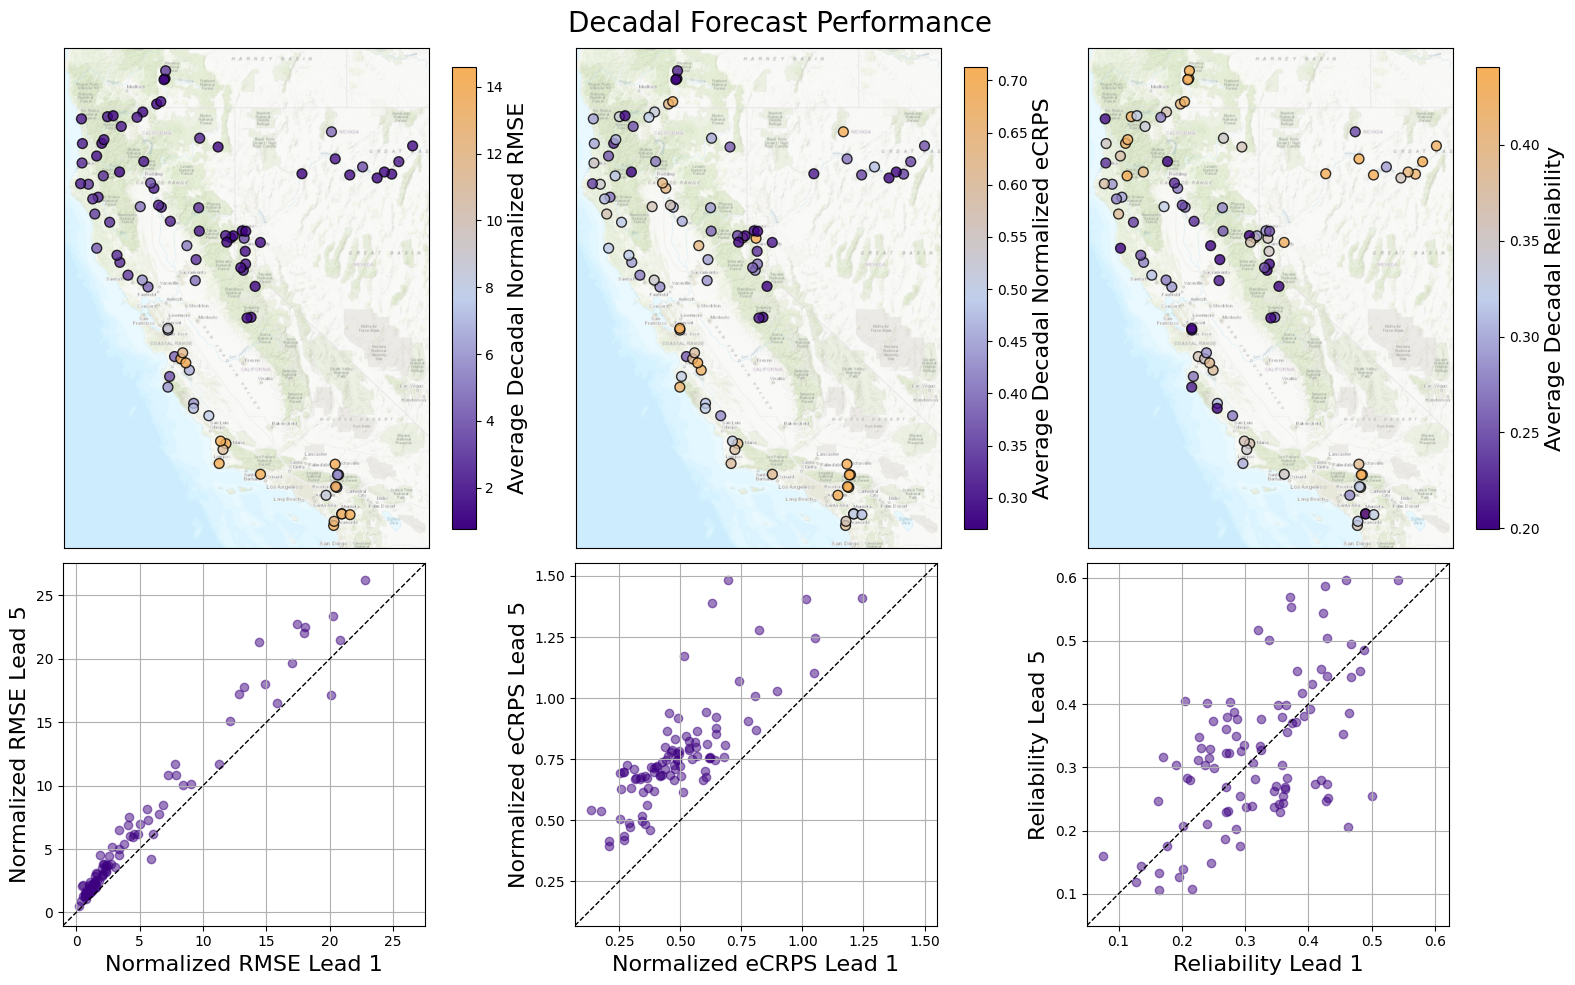

In [31]:
for agg_type in aggregation_periods:
    for flow in [0.9]:#flow_thresholds:
        logger.log(f"\nProcessing agg type = {agg_type}, threshold = {flow}")
        # make folders for plots: 
        folder_path = plots_path / f'plots_{agg_type}_Thresh{flow}/'
        folder_path.mkdir(parents=True, exist_ok=True)

        model_results, model_list = compile_model_results()

        metric_path = metric_folder / f"metrics_{agg_type}_Thresh{flow}.csv"
        decade_metric_path = metric_folder / f"metrics_{agg_type}_Thresh{flow}_decade.csv"
        if metric_path.exists():
            #read in metric_path:
            df_metric = pd.read_csv(metric_path)
            print('df_metric', df_metric.head())
            df_metric_decade = pd.read_csv(decade_metric_path)
            print('df_metric_decade', df_metric_decade.head())
        #otherwise:
        else:
            logger.log(f"Metric file {metric_path} does not exist. Skipping...")
            continue

        selected_sites = df_metric['site'].unique().tolist()
        selected_sites_decadal = df_metric_decade['site'].unique().tolist()

        # Verify length of chains (number of posterior draws)
        num_draws = model_results[model_list[0]]['trace'].posterior.draw.shape[0]
        logger.log(f"Number of posterior draws: {num_draws}")
        

        # PLOTS:
        plot_decadal_metric()
        #plot_mu_wet_time_lead_comp()
        #plot_model_comp_waic()
        #plot_model_comp_waic_ld15()
        #plot_beta_time_maps()
        #plot_beta_time_positive()

        # # plot illustration of wetness and forecast skill relationship:
        # plot_wetness_skill_illustration(df_metric, folder_path)
        # sites_for_illustration = ['AHOC1', 'BRGC1', 'COTC1', 'DLTC1', 'DOSC1', 'GYRC1', 'HAPC1', 'SEIC1', 'YDRC1']
        # plot_wetness_skill_illustration_subset(df_metric, folder_path, lead_time=1,
        #                                    sel_metric='eCRPS_mean', sel_metric_label='eCRPS', sel_metric_units= '(cfs)',
        #                                    sites=sites_for_illustration)

        # # checking for multicollinearity; examining other params besides wet time:
        # folder_path_global_params = folder_path / 'global_params'
        # folder_path_global_params.mkdir(parents=True, exist_ok=True)
        # plot_global_params_all()
        # plot_global_params_mu()
        # plot_global_params_mu_ld15()

        # # Convergence checks:
        # if config.check_convergence:
        #     folder_path_convergence = folder_path /'convergence'
        #     folder_path_convergence.mkdir(parents=True, exist_ok=True)
        #     plot_trace_global_chains()
        #     summarize_rhat_ess_global()
        #     # summarize_rhat_ess_site()
        #     # get_summaries_save()

        # # Basin characteristic plots
        # if basin_char:
        #     try:
        #         folder_path = plots_path / f'plots_{agg_type}_Thresh{flow}_basinchar'
        #         folder_path.mkdir(parents=True, exist_ok=True)

        #         model_results_basin_char, model_list_basin_char = compile_model_results_basinchar()

        #         summarize_basinchar_coeffs(model_results_basin_char, folder_path)
        #         plot_basinchar_effects(model_results_basin_char, folder_path)
        #         plot_basinchar_effects_horizontal(model_results_basin_char, folder_path)
        #         plot_model_comp_waic_with_basinchar(
        #             model_results=model_results,
        #             model_results_basin_char=model_results_basin_char,
        #             model_list=model_list,
        #             model_list_basin_char=model_list_basin_char,
        #             folder_path=folder_path
        #         )
        #         plot_model_comp_waic_ld15_with_basinchar(
        #             model_results=model_results,
        #             model_results_basin_char=model_results_basin_char,
        #             model_list=model_list,
        #             model_list_basin_char=model_list_basin_char,
        #             folder_path=folder_path
        #         )
                
        #     except Exception as e:
        #         logger.log(f"Error in basin characteristic plotting for agg_type={agg_type}, threshold={flow}: {e}")
        #         continue


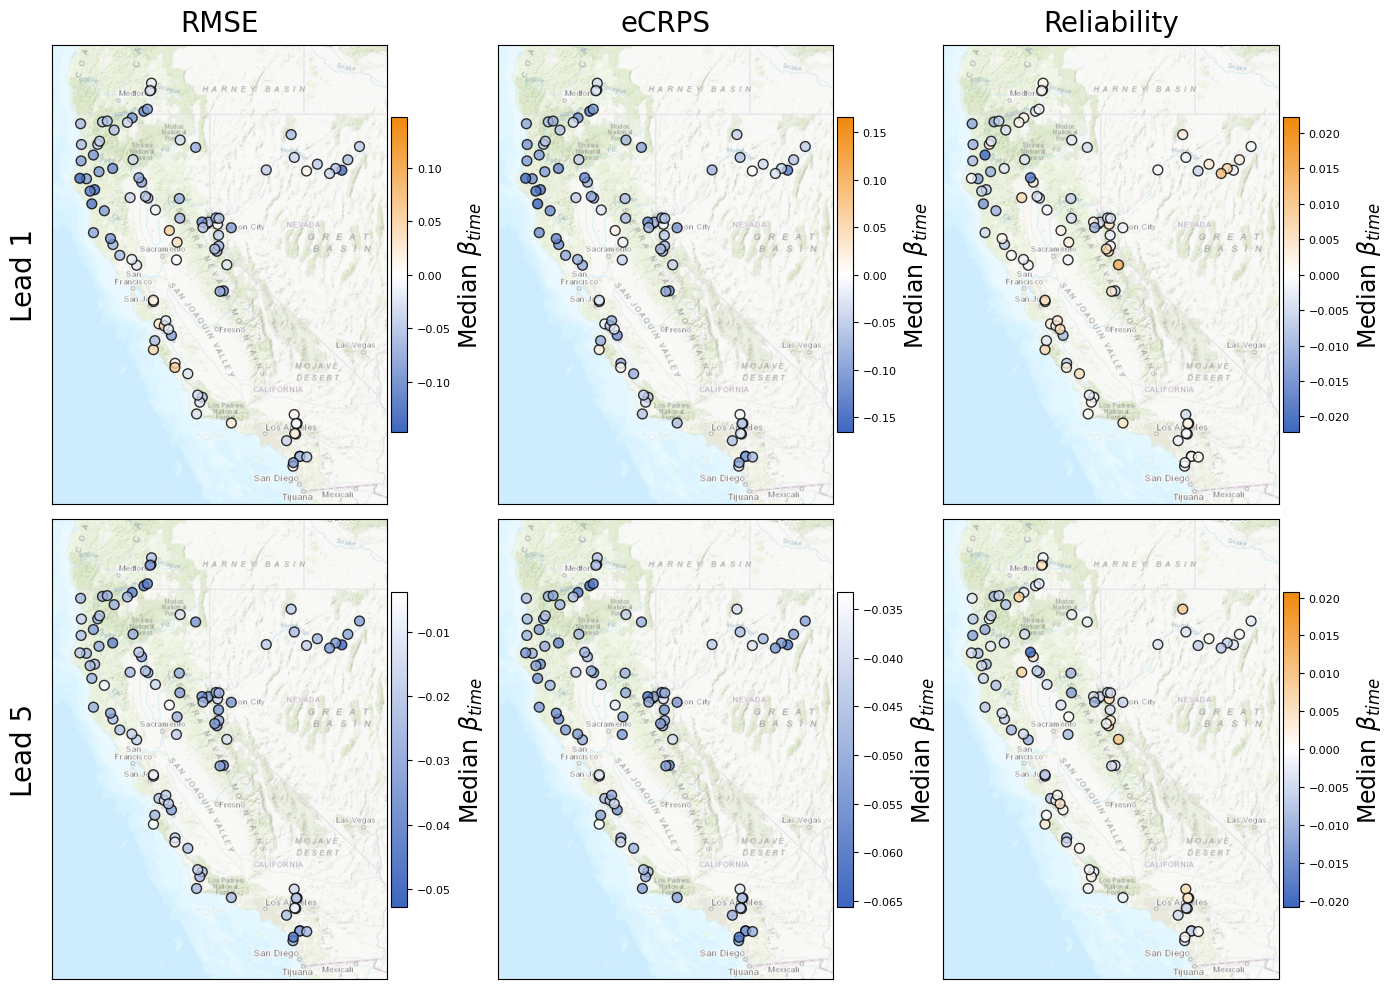

In [40]:
plot_beta_time_maps()

In [29]:
logger.end()